In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
model_path = os.path.join(base_path, "gaba_titration")
save_name = "test"
load_name = None
# load_name = "test"
# load_name = "control"
load_name = "control_6n_3tr_0p2_1p6"
# load_name = "no_nmda_6n_3tr_0p2_1p6"
# load_name = "non_ds_ach_6n_3tr_0p2_1p6"
# load_name = "non_ds_ach_no_nmda_6n_3tr_0p2_1p6"
# load_name = "control_6n_3tr_0p2_1p6_nmda0p004"
# load_name = "control_6n_3tr_0p2_1p6_nmda0p006"
# load_name = "control_6n_3tr_0p2_1p6_ach0p001_nmda0p004"
# load_name = "control_6n_3tr_0p2_1p6_ach0p001_nmda0p006"
# load_name = "control_6n_3tr_0p2_1p6_EIdelay20ms"
# load_name = "control_6n_3tr_0p2_1p6_nmda0p006_EIdelay20ms"

model_config = configs.sac_mode_config(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    record_tree=False,
)

# model_config["synprops"]["E"]["weight"] = 0.001

# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0
# model_config["synprops"]["NMDA"]["weight"] = 0.006

# model_config["synprops"]["E"]["delay"] += 20
# model_config["synprops"]["I"]["delay"] += 20

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_gaba_titration_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        # gaba_steps=[0.5, 1.],
        gaba_steps=[0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6],
        pool_sz=6,
    )

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
factors = list(d.keys())
rhos = list(d[factors[0]].keys())
idxs = list(d[factors[0]][rhos[0]].keys())

In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
metrics = {k: ana.get_sac_metrics(d[k]) for k in factors}

dir_labels = d[factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = ana.get_sac_thetas(d[factors[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)

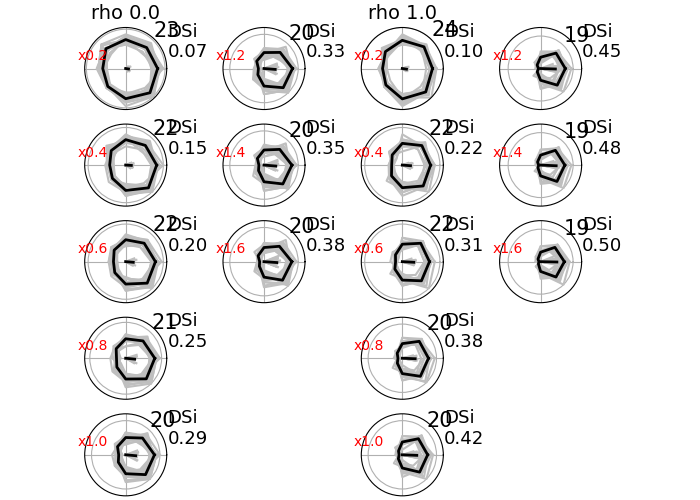

In [7]:
max_spikes = np.max([r["spikes"] for s in factors for r in metrics[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(factors))
splits = int(np.ceil(len(factors) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, (rho, m) in enumerate(metrics[factor].items()):
        polar_ax.append(polar_plot(
            m,
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=False,
            save=False,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i in range(len(rhos)):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14)

polar_fig.set_layout_engine("compressed")

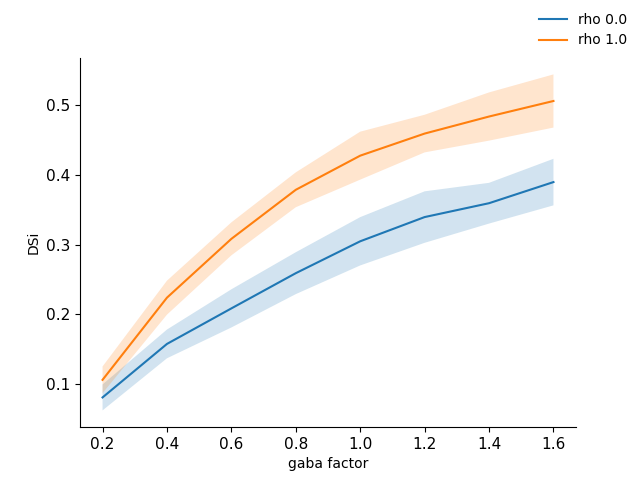

In [8]:
dsi_fig, dsi_ax = plt.subplots(1)

titration_dsis = {}
for rho in rhos:
    titration_dsis[rho] = {"nets": [], "avg": [], "std": []}
    for factor in factors:
        dsis = metrics[factor][rho]["DSis"]
        dsi_net_avgs = metrics[factor][rho]["DSis"].mean(axis=1)
        titration_dsis[rho]["nets"].append(dsi_net_avgs)
        titration_dsis[rho]["avg"].append(np.mean(dsi_net_avgs))
        titration_dsis[rho]["std"].append(np.std(dsi_net_avgs))
    titration_dsis[rho] = {m: np.array(v) for m, v in titration_dsis[rho].items()}
    titration_dsis[rho]["nets"] = titration_dsis[rho]["nets"].T
    dsi_ax.fill_between(
        factors, 
        titration_dsis[rho]["avg"] + titration_dsis[rho]["std"],
        titration_dsis[rho]["avg"] - titration_dsis[rho]["std"],
        alpha=0.2
    )
    dsi_ax.plot(factors, titration_dsis[rho]["avg"], label="rho " + str(rho))
        
dsi_ax.set_ylabel("DSi")
dsi_ax.set_xlabel("gaba factor")

dsi_fig.legend(frameon=False)
clean_axes(dsi_ax)

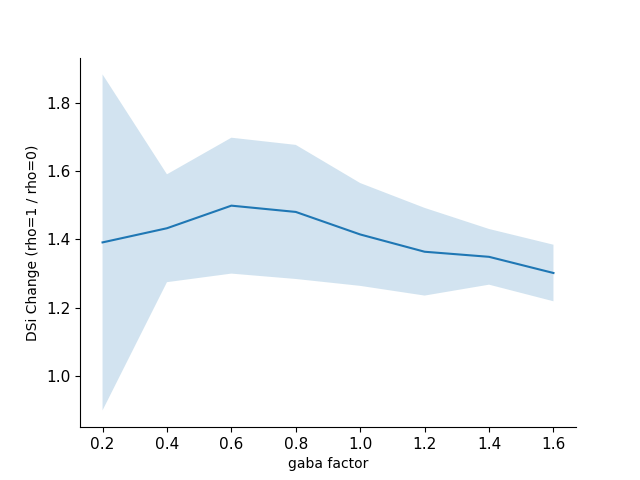

In [9]:
rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
dsi_effect_nets = titration_dsis[1.0]["nets"] / titration_dsis[0.0]["nets"]
dsi_effect_avg = np.mean(dsi_effect_nets, axis=0)
dsi_effect_std = np.std(dsi_effect_nets, axis=0)

rho_dsi_effect_ax.fill_between(
    factors, 
    dsi_effect_avg + dsi_effect_std,
    dsi_effect_avg - dsi_effect_std,
    alpha=0.2
)
rho_dsi_effect_ax.plot(factors, dsi_effect_avg)

rho_dsi_effect_ax.set_ylabel("DSi Change (rho=1 / rho=0)")
rho_dsi_effect_ax.set_xlabel("gaba factor")

clean_axes(rho_dsi_effect_ax)

In [24]:
avg_spikes = {
    fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}

wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

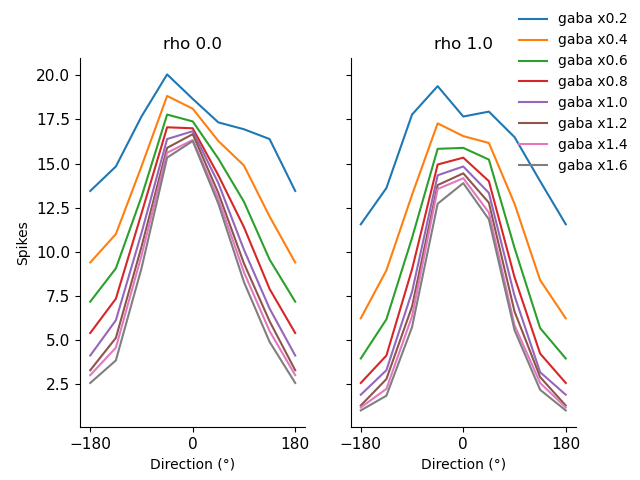

In [33]:
tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True)
for i, (ax, rho) in enumerate(zip(tuning_ax, rhos)):
    ax.set_xlabel("Direction (°)")
    ax.set_title("rho " + str(rho))
    for factor in factors:
        lbl = ("gaba x" + str(factor)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_spikes[factor][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes")
tuning_fig.legend(frameon=False)
clean_axes(tuning_ax)

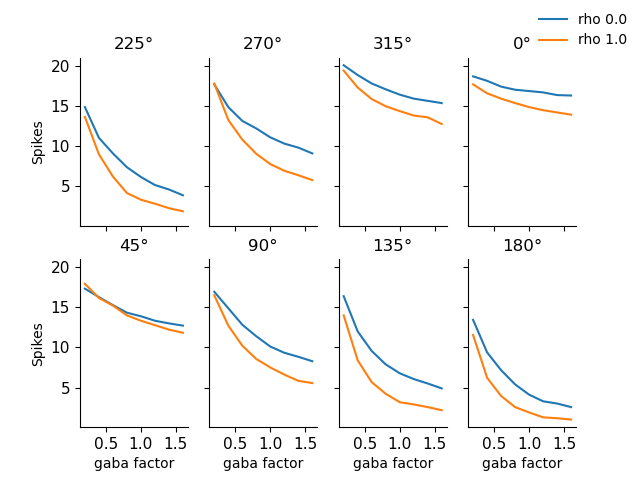

In [29]:
dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes")
    for ax in row:
        for rho in rhos:
            spks = [avg_spikes[factor][rho][i] for factor in factors]
            lbl = ("rho " + str(rho)) if not i else None
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i])
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("gaba factor")
        
dir_grid_fig.legend(frameon=False)
clean_axes(dir_grid_ax)

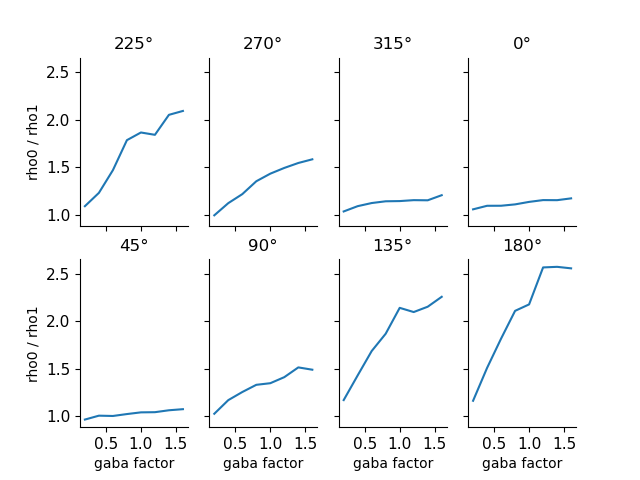

In [28]:
dir_mult_grid_fig, dir_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1")
    for ax in row:
        rho0_spks = np.array([avg_spikes[factor][0.0][i] for factor in factors])
        rho1_spks = np.array([avg_spikes[factor][1.0][i] for factor in factors])
        ax.plot(factors, rho0_spks / rho1_spks)
        ax.set_title("%i°" % dir_labels[i])
        i += 1

for col in dir_mult_grid_ax.T:
    col[-1].set_xlabel("gaba factor")
        
clean_axes(dir_mult_grid_ax)

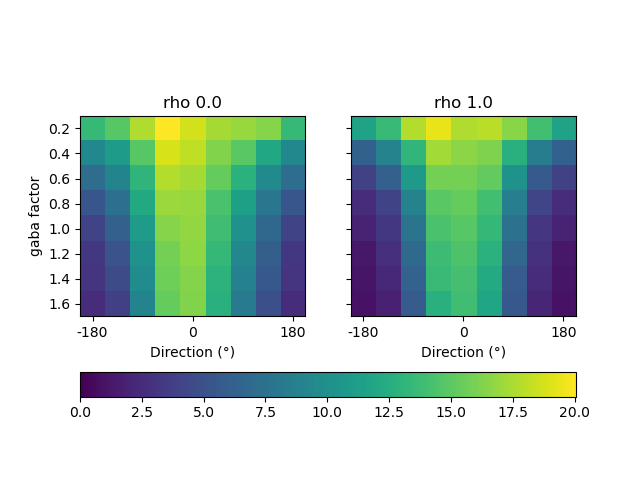

In [31]:
tuning_mat_fig, tuning_mat_ax = plt.subplots(1, 2, sharey=True)
# tuning_extent = (min(factors), max(factors), max(dirs_180_sorted), min(dirs_180_sorted))
# tuning_extent = (max(dirs_180_sorted), min(dirs_180_sorted), min(factors), max(factors))

avg_spike_mats = {
    rho: np.stack(
        [wrap_circ(avg_spikes[factor][rho][dir_sort]) for factor in factors], axis=0)
    for rho in rhos
}
avg_max_spikes = np.max([m.max() for m in avg_spike_mats.values()])
avg_spike_imgs = {}

vmax = avg_max_spikes
# vmax = 20.0

for i, (ax, rho) in enumerate(zip(tuning_mat_ax, rhos)):
    ax.set_xlabel("Direction (°)")
    ax.set_title("rho " + str(rho))
    avg_spike_imgs[rho] = ax.imshow(avg_spike_mats[rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(factors)))
    ax.set_yticklabels(factors)
    
tuning_mat_ax[0].set_ylabel("gaba factor")
tuning_mat_fig.colorbar(
    avg_spike_imgs[rhos[-1]], ax=tuning_mat_ax, orientation="horizontal")

In [15]:
close_button()